In [22]:
import torch
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
import math
from tqdm import tqdm
import mitdeeplearning as mdl

In [5]:
base_dir = "preprocessed_data"
program_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]

In [66]:
# Concatenate all piano events into one long list of events
piano_joined = []
for i in range(100,200):
    recording = np.load("./preprocessed_data/recording" + str(i) + ".npy", allow_pickle=True)
    instruments = np.load("./preprocessed_data/instruments" + str(i) + ".npy", allow_pickle=True)
    for j, instrument in enumerate(instruments):
        if instrument == 0:
            initial_pause = True
            for event in recording[j]:
                if event != 387: #remove initial pauses
                    initial_pause = False
                if initial_pause == False:
                    piano_joined.append(event)
                    
piano_joined = np.asarray(piano_joined)
piano_joined.shape

(845278,)

In [68]:
# get_batch: get random continuous segments of messages from vectorized_songs
# ARGUMENTS
# vectorized_songs: the sequence to pull from
# seq_length: length of the segmen to return
# batch_size: number of segments to return
# RETURN: two numpy arrays:
# x_batch: LxB, contains segments
# y_batch: LxB. y_batch[l, b] contains the message that comes after
# x_batch[l, b]
def get_batch(vectorized_songs, seq_length, batch_size):
    n = vectorized_songs.shape[0] - 1
    idx = np.random.choice(n-seq_length, batch_size)

    input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
    output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
    x_batch = torch.tensor(np.reshape(input_batch, [batch_size, seq_length]), dtype=torch.long).transpose(0, 1)
    y_batch = torch.tensor(np.reshape(output_batch, [batch_size, seq_length]), dtype=torch.long).transpose(0, 1)
    return x_batch, y_batch

In [70]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
# Only change is the view/expand in forward (accounts for batches)
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.shape[0], :].unsqueeze(1).expand(-1, x.shape[1], -1)
        return self.dropout(x)

class BaselineTransformer(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # message_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # heads: number of attention heads
    # attention_layers: number of attention layers
    # ff_size: size of the feedforward output at the end of the decoder
    def __init__(self, message_dim, embed_dim, heads, attention_layers, ff_size):
        super(BaselineTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        
        self.embedding = torch.nn.Embedding(message_dim, embed_dim)
        
        # An encoder takes the history of messages (added to their
        # associated instrument encoding and position encodings) and produces an encoding
        encoder_layer = torch.nn.TransformerEncoderLayer(embed_dim, heads, ff_size)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, attention_layers)

        # The encoding is passed through a linear layer to get the logits for the next message
        self.logits = torch.nn.Linear(embed_dim, message_dim)
        
        # Indicates the position of messages in time
        self.position_encoding = PositionalEncoding(embed_dim)
    
    # forward: generates a probability distribution for the next MIDI message
    # and the channel that issues the message, given a message history for the instrument
    # ARGUMENTS
    # history: an LxB tensor, where L is the length of each batch's message history,
    # and B is the batch size
    # RETURN: an LxBxD tensor containing the logits for the next message
    def forward(self, history):
        L = history.shape[0] # longest length
        B = history.shape[1] # batch size
        
        inputs = self.position_encoding(self.embedding(history))
        
        src_mask = torch.triu(torch.ones((L, L), dtype=torch.bool))
        src_mask.fill_diagonal_(False)
        encoding = self.encoder(inputs, mask=src_mask)
        
        # LxBxD
        message_dist = self.logits(encoding)
        
        return message_dist

In [71]:
# Optimization parameters:
num_training_iterations = 4000  # Increase this to train longer
batch_size = 16  # Experiment between 1 and 64
seq_length = 200  # Experiment between 50 and 500
learning_rate = 1e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = 388
embedding_dim = 256
heads = 4
attention_layers = 6
ff_size = 512

In [72]:
model = BaselineTransformer(vocab_size, embedding_dim, heads, attention_layers, ff_size)

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

def train_step(x, y): 
    #feed the current input into the model and generate predictions'''
    y_hat = model(x)
    #compute the loss!
    loss = loss_fn(y_hat.view(-1, vocab_size), y.flatten())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.data

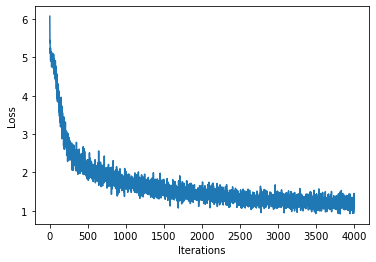

100%|██████████| 4000/4000 [1:02:07<00:00,  1.07it/s]


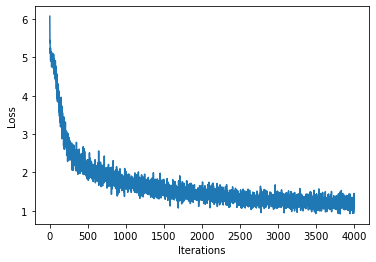

In [77]:
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):
  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(piano_joined, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss)
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    torch.save(model.state_dict(), 'trained_models_12_3_full/iter' + str(iter) + '.pth')

In [81]:
def generate_music(model, primer, gen_length=1000):
    gen_music=torch.tensor(primer).view(-1, 1)
    
    for i in range(gen_length):
        logits = model(gen_music[-200:])
        message = torch.multinomial(torch.nn.functional.softmax(logits[-1, 0], dim=0), 1).view(1, 1)
        gen_music = torch.cat((gen_music, message), dim=0)
        
    return gen_music

In [91]:
primer = [16]
instrument = 0 # Violin
gen_music = generate_music(model, primer)

In [92]:
to_save = np.array([0], dtype='object')
to_save[0] = gen_music.flatten().detach().numpy()
np.save('gen_recording.npy', to_save)
np.save('gen_instruments.npy', np.array([program_numbers[instrument]]))